In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from collections import Counter
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error,r2_score
import lightgbm as lgb

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))


In [3]:
dataset=(transactions
 .merge(items.drop(columns="item_name"),how="left")
 .assign(month=lambda x: x.eval("date_block_num%12+1"),year=lambda x: (x.date_block_num/12+2013).astype(int))
 .drop(columns="date")

)

In [4]:
dataset.query("year>2013")[["item_id","date_block_num","item_price"]]

,item_id,date_block_num,item_price
1267562,10297,12,749.000
1267563,10297,12,749.000
1267564,10297,12,749.000
1267565,10296,12,1599.000
1267566,10297,12,749.000
1267567,10298,12,399.000
1267568,10298,12,399.000
1267569,10298,12,399.000
1267570,10300,12,699.000
1267571,10300,12,699.000


Items can be mean-encoded by taking their mean and std, some products are highly variable. And then, within each shop, we will also include the same features

## Encoding of prices

In [5]:
item_price=dataset.query("year>2013").groupby("item_id").item_price.agg(["mean","std","median","max"]).fillna(0)
item_price.columns=["mean_by_item","std_by_item","median_by_item","max_by_item"]
item_price.reset_index(inplace=True)
item_price.head(2)

,item_id,mean_by_item,std_by_item,median_by_item,max_by_item
0,0,58.000,0.000,58.000,58.000
1,1,4490.000,0.000,4490.000,4490.000


In [6]:
shop_price=dataset.query("year>2013").groupby(["item_id","shop_id"]).item_price.agg(["mean","std","median","max"]).fillna(0).reset_index()
shop_price.rename(columns={"mean":"mean_by_shop","std":"std_by_shop",
                           "median":"median_by_shop","max":"max_by_shop"},inplace=True)
shop_price.head(2)

,item_id,shop_id,mean_by_shop,std_by_shop,median_by_shop,max_by_shop
0,0,54,58.000,0.000,58.000,58.000
1,1,55,4490.000,0.000,4490.000,4490.000


In [7]:
item_price_cat=dataset.query("year>2013").groupby("item_category_id").item_price.agg(["mean","std","median","max","min"]).fillna(0)
item_price_cat.columns=["mean_by_item_cat","std_by_item_cat","median_by_item_cat","max_by_item_cat","min_by_item_cat"]
item_price_cat.reset_index(inplace=True)
item_price_cat.head(2)

,item_category_id,mean_by_item_cat,std_by_item_cat,median_by_item_cat,max_by_item_cat,min_by_item_cat
0,2,2410.482,1129.737,2490.000,6090.000,148.000
1,3,2296.795,1452.959,2590.000,7490.000,122.590


In [8]:
shop_price_cat=dataset.query("year>2013").groupby(["item_category_id","shop_id"]).item_price.agg(["mean","std"]).fillna(0).reset_index()
shop_price_cat.rename(columns={"mean":"mean_by_shop_cat","std":"std_by_shop_cat"},inplace=True)
shop_price_cat.head(2)

,item_category_id,shop_id,mean_by_shop_cat,std_by_shop_cat
0,2,2,2369.329,1145.791
1,2,3,2331.891,1055.302


# Encoding of items sold

In [9]:
item_sold=(dataset.query("year>2013").groupby(["item_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby("item_id").item_cnt_day.agg(["mean","std","median","max"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold","std":"std_sold","median":"median_sold","max":"max_sold"})
)
item_sold.head(2)

,item_id,mean_sold,std_sold,median_sold,max_sold
0,0,1.000,0.000,1.000,1.000
1,1,1.200,0.447,1.000,2.000


In [10]:
shop_sold=(dataset.query("year>2013").groupby(["shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby("shop_id").item_cnt_day.agg(["mean","std","median","max"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold_shop","std":"std_sold_shop","median":"median_sold","max":"max_sold"})
)
shop_sold.head(2)

,shop_id,mean_sold_shop,std_sold_shop,median_sold,max_sold
0,2,939.045,240.924,908.500,1921.000
1,3,825.273,175.834,767.000,1275.000


In [11]:
cat_sold=(dataset.query("year>2013").groupby(["item_category_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby("item_category_id").item_cnt_day.agg(["mean","std","median","max","min"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold_category","std":"std_sold_category","median":"median_sold_category",
                 "max":"max_sold_category","min":"min_sold_category"})
)
cat_sold.head(2)

,item_category_id,mean_sold_category,std_sold_category,median_sold_category,max_sold_category,min_sold_category
0,2,375.364,284.702,353.000,1339.000,82.000
1,3,1055.409,441.204,1017.000,2459.000,559.000


In [12]:
shop_cat_sold=(dataset.query("year>2013").groupby(["item_category_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .groupby(["item_category_id","shop_id"]).item_cnt_day.agg(["mean","std","median"]).fillna(0)
 .reset_index()
 .rename(columns={"mean":"mean_sold_category_shop","std":"std_sold_category_shop",
                  "median":"median_sold_category_shop"})
)
shop_cat_sold.head(2)

,item_category_id,shop_id,mean_sold_category_shop,std_sold_category_shop,median_sold_category_shop
0,2,2,8.211,5.769,7.000
1,2,3,6.000,3.986,6.000


In [13]:
aggregated_data=(dataset
                 
.drop(columns=["year","item_price","month","item_category_id"])
 
.groupby(["date_block_num","shop_id","item_id"]).sum()
 .reset_index()
)

In [16]:
preX=(aggregated_data
.assign(month=lambda x: x.eval("date_block_num%12+1"),year=lambda x: (x.date_block_num/12+1).astype(int))
 .merge(items.drop(columns="item_name"),how="left")
 
 .merge(item_price,how="left")
 .merge(shop_price,how="left")
 
 .merge(item_price_cat,how="left")
 .merge(shop_price_cat,how="left")
 
 .merge(item_sold,how="left")
 .merge(shop_sold,how="left")
 .merge(cat_sold,how="left")
 .merge(shop_cat_sold,how="left")


)
past_month=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+1)
 .query("date_block_num>=0")
 .rename(columns={"item_cnt_day":"prev_month_value1"})
)

past_month2=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+2)
 .rename(columns={"item_cnt_day":"prev_month_value2"})
)

past_month3=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+3)
 .rename(columns={"item_cnt_day":"prev_month_value3"})
)
past_month4=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+4)
 .rename(columns={"item_cnt_day":"prev_month_value4"})
)
past=["prev_month_value"+str(i) for i in range(1,5)]
preX2=(preX
       .merge(past_month,how="left")
       .merge(past_month2,how="left")
       .merge(past_month3,how="left")
       .merge(past_month4,how="left")
       
       .drop(columns=["shop_id","item_id","item_category_id"])
      )
preX2[past]=preX2[past].fillna(0)

preX2=preX2.sample(frac=1,replace=False)

In [17]:
validation="(year==3 and month==10)"
preX2
X_val = preX2.query(validation).drop(
    columns=["item_cnt_day","date_block_num","month"])
y_val = preX2.query(validation).item_cnt_day.pipe(
    np.clip, a_max=20, a_min=0)

training="not "+validation
X_train = preX2.query(training).drop(
    columns=["item_cnt_day","date_block_num","month"])
y_train = preX2.query(training).item_cnt_day.pipe(
    np.clip, a_max=20, a_min=0)


In [18]:
print(X_train.shape)
print(X_val.shape)

(1577593, 34)
(31531, 34)


In [19]:
train_data=lgb.Dataset(X_train,y_train)
val_data=lgb.Dataset(X_val,y_val)


In [26]:
list(range(1,9))

[1, 2, 3, 4, 5, 6, 7, 8]

In [20]:
scores=[]
for i in range(6,9):
    param = {'num_leaves': 2**i,
             'objective': 'regression',
            "metric":["l2_root"],
            "learning_rate":0.01,
            "seed":32}
    gbm = lgb.train(param, train_data,num_boost_round=10000, valid_sets=[val_data],
                    early_stopping_rounds=20,verbose_eval=100)
    scores.append(gbm.best_score["valid_0"]["rmse"])

Training until validation scores don't improve for 20 rounds.
[100]	valid_0's rmse: 2.01529
[200]	valid_0's rmse: 1.89342
[300]	valid_0's rmse: 1.83146
[400]	valid_0's rmse: 1.79059
[500]	valid_0's rmse: 1.76169
[600]	valid_0's rmse: 1.74118
[700]	valid_0's rmse: 1.72838
[800]	valid_0's rmse: 1.72122
[900]	valid_0's rmse: 1.71577
[1000]	valid_0's rmse: 1.71188
Early stopping, best iteration is:
[1042]	valid_0's rmse: 1.7097
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's rmse: 1.98829
[200]	valid_0's rmse: 1.83615
[300]	valid_0's rmse: 1.78093
[400]	valid_0's rmse: 1.74742
[500]	valid_0's rmse: 1.72808
[600]	valid_0's rmse: 1.71857
[700]	valid_0's rmse: 1.71041
Early stopping, best iteration is:
[772]	valid_0's rmse: 1.70696
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's rmse: 1.97747
[200]	valid_0's rmse: 1.80879
[300]	valid_0's rmse: 1.7635
[400]	valid_0's rmse: 1.73515
[500]	valid_0's rmse: 1.72514
[600]	valid_0's rmse: 1.

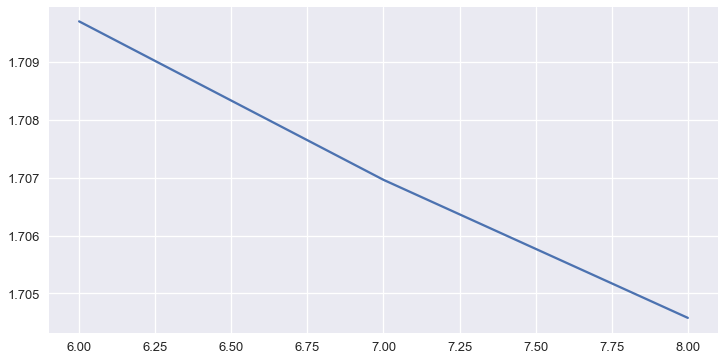

In [21]:
#LigtGBM regular boosting ahieved 1.722 loss. 
plt.plot(range(6,9),scores)

In [22]:
y_pred=np.clip(gbm.predict(X_train, num_iteration=gbm.best_iteration),a_max=20,a_min=0)
print('The rmse of prediction is:', mean_squared_error(y_train,y_pred) ** 0.5)
print('The r2 is:',r2_score(y_train, y_pred))

y_pred=np.clip(gbm.predict(X_val, num_iteration=gbm.best_iteration),a_max=20,a_min=0)
print('The rmse of prediction is:', mean_squared_error(y_val,y_pred) ** 0.5)
print('The r2 is:',r2_score(y_val, y_pred))

The rmse of prediction is: 1.48987143384
The r2 is: 0.66620244028
The rmse of prediction is: 1.7045785302
The r2 is: 0.548888359868


In [24]:
pd.DataFrame({"cols":gbm.feature_name(),"im":gbm.feature_importance()})

,cols,im
0,year,9866
1,mean_by_item,11688
2,std_by_item,12612
3,median_by_item,5740
4,max_by_item,5792
5,mean_by_shop,5367
6,std_by_shop,6285
7,median_by_shop,3285
8,max_by_shop,2585
9,mean_by_item_cat,2412


In [27]:
#Retrain on full set

X = preX2.drop(
    columns=["item_cnt_day","date_block_num","month"])
y = preX2.item_cnt_day.pipe(
    np.clip, a_max=20, a_min=0)
joint_data=lgb.Dataset(X,y)
param = {'num_leaves': 2**8,
             'objective': 'regression',
            "metric":["l2_root"],
            "learning_rate":0.01,
            "seed":32}
gbm = lgb.train(param, joint_data,num_boost_round=gbm.best_iteration,verbose_eval=100)

## Keras

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, Activation,Dropout, BatchNormalization
# from keras import backend as K
# from keras import optimizers
# import keras
# X_train_clean=X_train.dropna()
# X_val_clean=X_val.dropna()

# y_train_clean=y_train[X_train_clean.index]
# y_val_clean=y_val[X_val_clean.index]

# def trim_mse(y_true,y_pred):
#     y_pred=K.clip(y_pred,0,20)
#     mse=K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
#     return mse

# def rmse(y_true,y_pred):
#     mse=K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
#     return mse

# def coeff_determination(y_true, y_pred):
#     y_pred=K.clip(y_pred,0,20)
#     SS_res =  K.sum(K.square( y_true-y_pred )) 
#     SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# def clipped_linear(x):
#     return K.clip(x,0,20)  

# model = Sequential([
#     Dense(1024, input_shape=(19,)),
#     BatchNormalization(),
#     Activation('tanh'),
#     Dropout(0.1),
#     Dense(512),
#     Activation('tanh'),
#     Dropout(0.1),
#     BatchNormalization(),
#     Dense(256),
#     Activation('tanh'),
#     BatchNormalization(),
#     Dense(256),
#     Activation('tanh'),
#     BatchNormalization(),
#     Dense(256),
#     Activation('tanh'),
#     BatchNormalization(),
#     Dense(256),
#     Activation('tanh'),
#     Dense(1,activation=clipped_linear)
# ])
# sgd=optimizers.Adam()
# model.compile(optimizer=sgd,
#               loss="mse",
#               metrics=[coeff_determination,trim_mse],
#             )
# model.fit(X_train_clean,y_train_clean,epochs=10,batch_size=1024,
#          validation_data=(X_val_clean,y_val_clean))

## Predict for training set

In [30]:
X_test=(test
.assign(date_block_num=34,month=11,year=3)
.merge(items.drop(columns="item_name"),how="left")
  .merge(item_price,how="left")
 .merge(shop_price,how="left")
 
 .merge(item_price_cat,how="left")
 .merge(shop_price_cat,how="left")
 
 .merge(item_sold,how="left")
 .merge(shop_sold,how="left")
 .merge(cat_sold,how="left")
 .merge(shop_cat_sold,how="left")
 #.drop(columns=["shop_id","item_id","item_category_id"]) 
).drop(columns="ID")

past_month=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+1)
 .rename(columns={"item_cnt_day":"prev_month_value1"})
)

past_month2=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+2)
 .rename(columns={"item_cnt_day":"prev_month_value2"})
)

past_month3=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+3)
 .rename(columns={"item_cnt_day":"prev_month_value3"})
)

past_month4=(preX.groupby(["item_id","shop_id","date_block_num"])
 .item_cnt_day.sum().reset_index()
 .assign(date_block_num=lambda x: x.date_block_num+4)
 .rename(columns={"item_cnt_day":"prev_month_value4"})
)

past=["prev_month_value"+str(i) for i in range(1,5)]
preX2=(X_test
       .merge(past_month,how="left")
       .merge(past_month2,how="left")
       .merge(past_month3,how="left")
       .merge(past_month4,how="left")
       
       .drop(columns=["shop_id","item_id","item_category_id"])
      )
preX2[past]=preX2[past].fillna(0)



In [40]:
y_test=np.clip(gbm.predict(preX2),a_min=0,a_max=20)

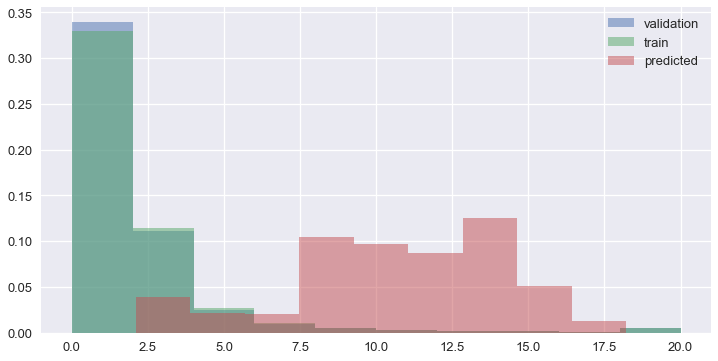

In [41]:
plt.hist(y_val,density=1,alpha=0.5,label="validation")
plt.hist(y_train,density=1,alpha=0.5,label="train")
plt.hist(y_test,alpha=0.5,density=1,label="predicted")
plt.legend()

In [54]:
mydataset=y.agg(["median","std"])

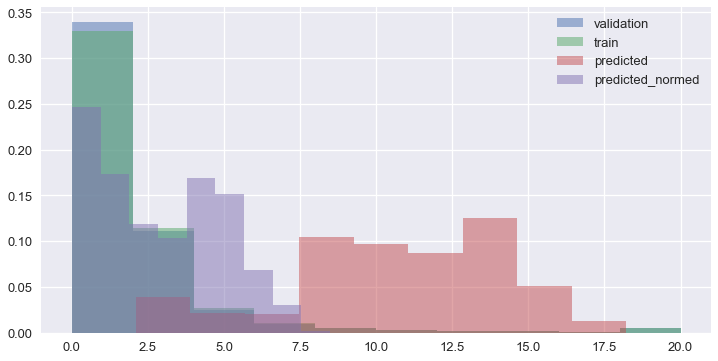

In [55]:
normed=(y_test-y_test.mean())/y_test.std()
y_test_normed=np.clip((normed+mydataset["median"])*mydataset["std"],0,20)
plt.hist(y_val,density=1,alpha=0.5,label="validation")
plt.hist(y_train,density=1,alpha=0.5,label="train")
plt.hist(y_test,alpha=0.5,density=1,label="predicted")
plt.hist(y_test_normed,alpha=0.5,density=1,label="predicted_normed")
plt.legend()

In [63]:
results=pd.DataFrame({"ID":test.ID,"item_cnt_month":y_test})
results.to_csv("xgboost_notext_norming_no.csv.gz",compression="gzip",index=False)

In [64]:
results

,ID,item_cnt_month
0,0,14.976
1,1,12.645
2,2,15.152
3,3,12.211
4,4,12.201
5,5,12.715
6,6,12.334
7,7,15.649
8,8,13.978
9,9,14.673
